This is a notebook that analyzes the files created to describe the dataset before the quality control step.

The files were created using commands:

1. Data description -> General distribution of depth, missingness, heterozygosity (.vchk file output)
bcftools stats joint.hg38.vcf.gz > joint.hg38.vchk

2. Generate a summary of the number of SNPs and Ts/Tv ratio for each FILTER category. (.FILTER.summary file output)
vcftools --gzvcf joint.hg38.vcf.gz --FILTER-summary --out joint.hg38.PRE-QC
 
3. Site missingness -> Generate a file reporting the missingness on a per-site basis. (.lmiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-site --out joint.hg38.PRE-QC

4. Individual missingness -> Generate a file reporting the missingness on a per-individual basis.(.imiss file output)
vcftools --gzvcf joint.hg38.vcf.gz --missing-indv --out joint.hg38.PRE-QC

5. Site depth -> Generate a file containing the mean depth per site across all individuals. (ldepth.mean file output)
vcftools --gzvcf joint.hg38.vcf.gz --site-mean-depth --out joint.hg38.PRE-QC 

6. Individual depth -> Generate a file containing the mean depth per individual. (.idepth file output)
vcftools --gzvcf joint.hg38.vcf.gz --depth --out joint.hg38.PRE-QC

7. Individual heterozygosity (.het file output)
vcftools --gzvcf joint.hg38.vcf.gz --het --out joint.hg38.PRE-QC

bcftools version: 1.9-94-g9589876
vcftools version: 0.1.15

Short summary of what we expect to learn from each file

1. vchk : stats by non-reference allele frequency, depth distribution, stats by quality and per-sample counts, singleton stats, etc. are included in this file

2. FILTER.summary : Generates a summary of the number of SNPs and Ts/Tv ratio for each FILTER category

3. lmiss : reports the missingness on a per-site basis

4. imiss : reports the missingness on a per-individual basis

5. ldepth.mean : contains the mean depth per site averaged across all individuals

6. idepth : contains the mean depth per individual

7. het : Calculates a measure of heterozygosity on a per-individual basis. Specfically, the inbreeding coefficient, F, is estimated for each individual using a method of moments

In [1]:
# Import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Check the mean depth per chromosome using ldepth.mean file
# Does each chromosome have similar mean depth or is there a variation? 
# Are there regions in each chromosomes that have smaller mean depth than other?


notebook_path = os.path.abspath("preQC_general_analysis.ipynb")
depth_file_path = os.path.join(os.path.dirname(notebook_path), "data/joint.hg38.PRE-QC.ldepth.mean")

# Read the mean depth file and divide the info into chromosomes.
per_chr_depth = {}
with open(depth_file_path, 'r') as f:
    f.readline()  # skip header
    for line in f:
        ch, depth = line.split('\t')[0][3:], float(line.split('\t')[2])
        if ch not in per_chr_depth.keys():
            print(ch)
            per_chr_depth[ch] = [depth]
        else:
            per_chr_depth[ch].append(depth)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X
Y


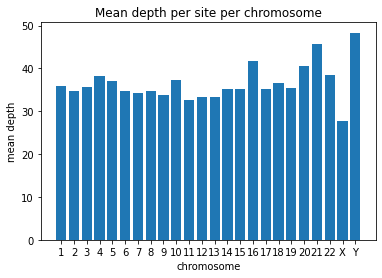

In [23]:
# Plot the mean depth of each chromosome 
plt.bar(list (per_chr_depth.keys()),[np.mean(per_chr_depth[i]) for i in per_chr_depth.keys()])
plt.title('Mean depth per site per chromosome')
plt.xlabel('chromosome')
plt.ylabel('mean depth')
plt.show()

In [14]:
# There's a lot of variation in the mean depth per site. What's the distribution of those mean depths per chromosome? 
# How much do they actually vary?

def make_cummulant(depths):

    # Show a cumulant graph for the distribution of mean depth values
    bins = np.arange(0, 101, 1)      # there are some big outliers but most of the distribution is around 0 - 70 mean depth
    depth_values, bins, _ = plt.hist(depths, bins=bins)


    # Calculate the cumulant for BLAST noref identities
    depth_total = float(sum(depth_values))

    depth_values_fractions = [0.0]
    current_total = 0.0
    for i in depth_values:
        current_total += (i/depth_total)
        depth_values_fractions.append(current_total)

    return(bins, depth_values_fractions)
    

In [24]:
def make_4_cummulant_graphs(chromosomes):
    """
    Given 4 chromosome labels, create a graph with 4 panels that show
    the distribution of the mean depth scores.
    """
    # Show a cumulant graph for the distribution of identity scores
    bins1, fractions1 = make_cummulant(per_chr_depth[chromosomes[0]])
    bins2, fractions2 = make_cummulant(per_chr_depth[chromosomes[1]])
    bins3, fractions3 = make_cummulant(per_chr_depth[chromosomes[2]])
    bins4, fractions4 = make_cummulant(per_chr_depth[chromosomes[3]])

    plt.clf()
    fig = plt.figure()
    gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
    (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

    ax1.plot(bins1, fractions1, label='chr '+chromosomes[0], color='blue')
    ax2.plot(bins2, fractions2, label='chr '+chromosomes[1], color='red')
    ax3.plot(bins3, fractions3, label='chr '+chromosomes[2], color='magenta')
    ax4.plot(bins4, fractions4, label='chr '+chromosomes[3], color='green')

    #plt.plot(bins, fractions)
    ax3.set_xlabel('mean depth')
    ax3.set_ylabel('fraction of sites')
    fig.legend()
    fig.suptitle('What is the distribution of mean depth values for different chromosomes?')
    plt.show()

<Figure size 432x288 with 0 Axes>

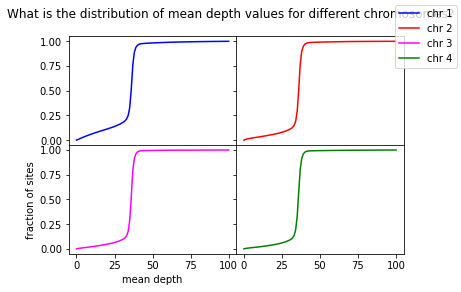

<Figure size 432x288 with 0 Axes>

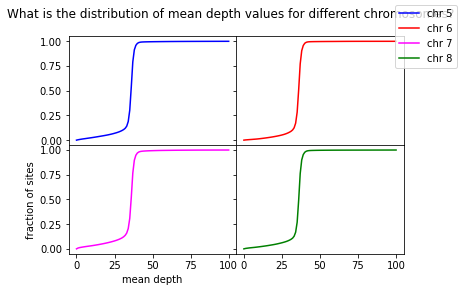

<Figure size 432x288 with 0 Axes>

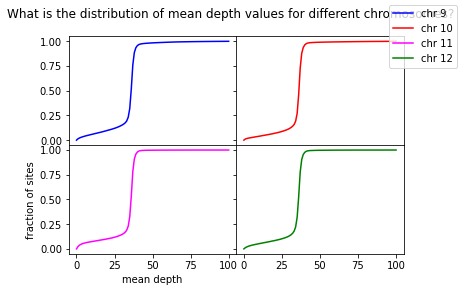

<Figure size 432x288 with 0 Axes>

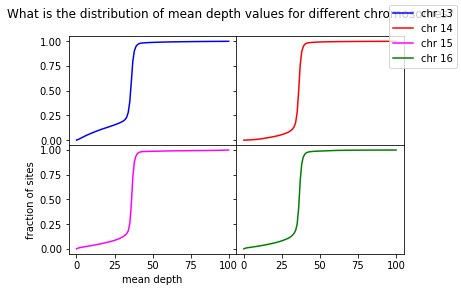

<Figure size 432x288 with 0 Axes>

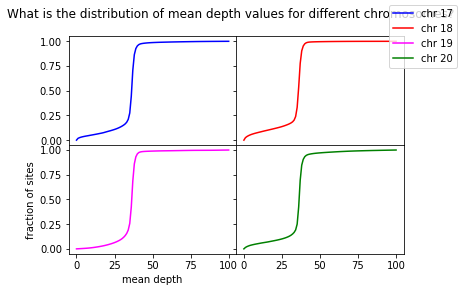

<Figure size 432x288 with 0 Axes>

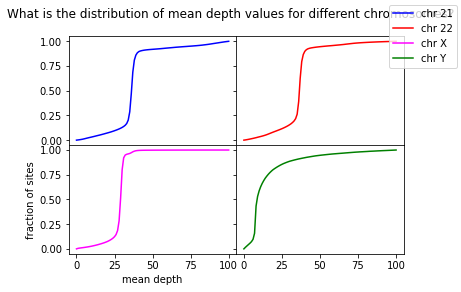

In [26]:
# Show a cumulant graph for the distribution of identity scores
make_4_cummulant_graphs(['1', '2', '3', '4'])
make_4_cummulant_graphs(['5', '6', '7', '8'])
make_4_cummulant_graphs(['9', '10', '11', '12'])
make_4_cummulant_graphs(['13', '14', '15', '16'])
make_4_cummulant_graphs(['17', '18', '19', '20'])
make_4_cummulant_graphs(['21', '22', 'X', 'Y'])

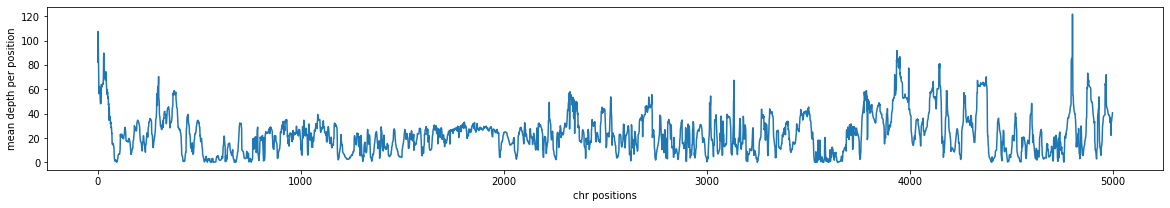

In [31]:
# What is the mean depth for the consecutive positions in the chromosome?

dist_range = [0,5000] # position range we want to plot (start, end)

plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(dist_range[0],dist_range[1]), per_chr_depth['1'][dist_range[0]:dist_range[1]])
plt.ylabel('mean depth per position')
plt.xlabel('chr positions')
plt.show()
